### LETS DO SOME JOINT TRACKING

In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt 

In [2]:
## RERUN setup 

PORT = 8813
rr.init("SHOUT_TRACKING")
rr.connect(addr=f'127.0.0.1:{PORT}')
# rr.save("outliers_0328.rrd")

[2024-03-31T19:04:35Z WARN  re_sdk_comms::buffered_client] Failed to send message after 3 attempts: Failed to connect to Rerun server at 127.0.0.1:8813: Connection refused (os error 111)
[2024-03-31T19:04:38Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-03-31T19:04:38Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-03-31T19:04:38Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.


In [3]:
b3d.LIBRARY = b3d.MeshLibrary()
b3d.LIBRARY.num_objects

0

In [4]:
#######
# Data 
#######

"""get data -- first few frames contain background only (overlaps with part1 video), and SHOUT comes in"""
path = os.path.join(b3d.get_assets_path(), "shared_data_bucket/input_data/demo_reel_place_and_pickup.r3d.video_input_part2.npz")  # frames 44 to 76 in original data
video_input = b3d.VideoInput.load(path) 

subsampling_frame = 5

image_width, image_height, fx,fy, cx,cy,near,far = np.array(video_input.camera_intrinsics_depth)
image_width, image_height = int(image_width), int(image_height)
fx,fy,cx,cy,near,far = float(fx),float(fy), float(cx),float(cy),float(near),float(far)

rgbs_all = video_input.rgb / 255.0
xyzs = video_input.xyz[:-1:subsampling_frame, ...]
rgbs = rgbs_all[:-1:subsampling_frame, ...]

# Resize rgbs to be same size as depth.
rgbs_resized = jnp.clip(jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    rgbs, (xyzs.shape[1], xyzs.shape[2], 3), "linear"
), 0.0, 1.0)
 
# # Get GT camera poses.
gt_camera_poses = jax.vmap(lambda x,y: Pose(x,y), in_axes=(0,0))(
    video_input.camera_positions,
    video_input.camera_quaternions
)[::subsampling_frame, ...]
print(rgbs_resized.shape)  # how many frames are there


(33, 256, 192, 3)


##### Part 1 Background mesh building + Initialize camera pose 

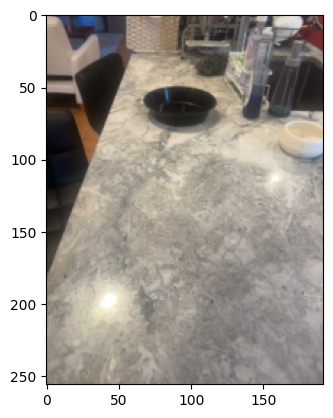

In [5]:
TIME_FOR_MESH = 0 

plt.imshow(rgbs_resized[TIME_FOR_MESH])

In [6]:
#######
# Build a FULL mesh of the background scene from the 
# last frame that does NOT contain the SHOUT. (not masking anything out)
# TODO: Use mesh + inferred pose from previous part of the demo. 
#######


point_cloud_for_mesh = xyzs[TIME_FOR_MESH].reshape(-1, 3)
colors_for_mesh = rgbs_resized[TIME_FOR_MESH].reshape(-1, 3)

_bg_vertices, bg_faces, bg_vertex_colors, bg_face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud_for_mesh, 
    colors_for_mesh, 
    point_cloud_for_mesh[:,2] / fx 
)

bg_object_pose = Pose.from_translation(_bg_vertices.mean(0))  # (approximate) CAMERA frame object pose
bg_vertices = bg_object_pose.inverse().apply(_bg_vertices)  # (approximate) WORLD frame vertices


#######
# Build a subset mesh of the background
#######
subset1 = ((point_cloud_for_mesh < point_cloud_for_mesh.mean(0) * 1.5)).all(1)
subset2 = ((point_cloud_for_mesh > point_cloud_for_mesh.mean(0) * 0.75)).all(1)
subset = subset1 | subset2 

point_cloud_subset = point_cloud_for_mesh[subset]
colors_for_mesh_subset = colors_for_mesh[subset]


_bg_vertices_subset, bg_faces_subset, bg_vertex_colors_subset, bg_face_colors_subset = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud_subset, colors_for_mesh_subset, point_cloud_subset[:,2] / fx )


bg_object_pose_subset = Pose.from_translation(_bg_vertices_subset.mean(0))  # CAMERA frame object pose
bg_vertices_subset_unaligned = bg_object_pose_subset.inverse().apply(_bg_vertices_subset)  # WORLD frame vertices

# align the subset points to same world frame coords as whole bg points
vertices_subset_to_whole = bg_object_pose.as_matrix() @ jnp.linalg.inv(bg_object_pose_subset.as_matrix())
vertices_subset_to_whole_xfm = Pose(position=vertices_subset_to_whole[:3,-1], 
                                    quaternion=Pose.identity_quaternion)
bg_vertices_subset = vertices_subset_to_whole_xfm.apply(bg_vertices_subset_unaligned)

In [7]:
b3d.LIBRARY = b3d.MeshLibrary()  # reset just in case 

## Register the full background mesh into the library
b3d.LIBRARY.add_object(bg_vertices, bg_faces, bg_vertex_colors, "background")

## Register the partial background mesh into the library
b3d.LIBRARY.add_object(bg_vertices_subset, bg_faces_subset, bg_vertex_colors_subset, "background_partial")

b3d.LIBRARY.names

['background', 'background_partial']

##### Part 1.5 Inference setup 

In [8]:
#######
# setup renderer and model functions
#######

renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)
from b3d.model import model_multiobject_gl_factory

# initialize the model. 
model = model_multiobject_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(lambda key, trace, choices: model.update(key, trace, choices, genjax.Diff.tree_diff_no_change(trace.get_args()))[0])

In [9]:
# trace handlers 
enumerator_cam_pose = b3d.make_enumerator(["camera_pose"])
enumerator_obj_pose = b3d.make_enumerator(["object_pose_1"])  # obj_pose_0 is for background mesh
enumerator_observations = b3d.make_enumerator(["observed_rgb", "observed_depth"])

In [10]:
## setup enumeration 
translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.01, 0.01, 5),
        jnp.linspace(-0.01, 0.01, 5),
        jnp.linspace(-0.01, 0.01, 5),
    ),
    axis=-1,
).reshape(-1, 3))

rotation_deltas = jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 100),
    Pose.identity(),
    0.001, 100.0
)

In [11]:
@jax.jit
def enumerative_proposal_camera_pose(trace, key):
    key = jax.random.split(key)[0]

    test_poses_tr = trace["camera_pose"] @ translation_deltas
    
    print(test_poses_tr.shape)
    
    potential_scores = enumerator_cam_pose.enumerate_choices_get_scores(
        trace, key, test_poses_tr
    )
    
    # top k translations 
    k = 5
    top_scores, top_pose_idxs = jax.lax.top_k(potential_scores, k)

    def _eval_trace(curr_best_pose_score, pose_idx):
        _, curr_best_score = curr_best_pose_score

        test_poses_rot = test_poses_tr[pose_idx] @ rotation_deltas
        potential_scores = enumerator_cam_pose.enumerate_choices_get_scores(
            trace, key, test_poses_rot
        )
        top_idx = potential_scores.argmax()
        top_score = jnp.max(potential_scores)
        curr_best_pose_score = jax.lax.cond(
            top_score > curr_best_score,
            lambda : (test_poses_rot[top_idx], top_score),
            lambda : curr_best_pose_score
        )
        
        return curr_best_pose_score, curr_best_score
          
    top_pose_and_score, _ = jax.lax.scan(_eval_trace, 
                                        (test_poses_tr[top_pose_idxs[0]], top_scores[0]),
                                        top_pose_idxs)
    
    trace = enumerator_cam_pose.update_choices(
        trace, jax.random.PRNGKey(0), top_pose_and_score[0]
    )
    return trace, key

@jax.tree_util.Partial(jax.jit, static_argnames=('obj_idx'))
def enumerative_proposal_object_pose(cam_pose, obj_idx, trace, key):
    key = jax.random.split(key)[0]

    test_poses_tr = trace[f"object_pose_{obj_idx}"] @ translation_deltas
    
    # update current cam pose (inferred from bg previously)
    trace = update_jit(jax.random.PRNGKey(0), trace, genjax.choice_map({"camera_pose": cam_pose})) 
    
    potential_scores = enumerator_obj_pose.enumerate_choices_get_scores(
        trace, jax.random.PRNGKey(0), test_poses_tr
    )

    # top k translations 
    k = 5
    top_scores, top_pose_idxs = jax.lax.top_k(potential_scores, k)

    def _eval_trace(curr_best_pose_score, pose_idx):
        _, curr_best_score = curr_best_pose_score

        test_poses_rot = test_poses_tr[pose_idx] @ rotation_deltas
        potential_scores = enumerator_obj_pose.enumerate_choices_get_scores(
            trace, jax.random.PRNGKey(0), test_poses_rot
        )
        top_idx = potential_scores.argmax()
        top_score = jnp.max(potential_scores)
        curr_best_pose_score = jax.lax.cond(
            top_score > curr_best_score,
            lambda : (test_poses_rot[top_idx], top_score),
            lambda : curr_best_pose_score
        )
        
        return curr_best_pose_score, curr_best_score
          
    top_pose_and_score, _ = jax.lax.scan(_eval_trace, 
                                        (test_poses_tr[top_pose_idxs[0]], top_scores[0]),
                                        top_pose_idxs)
    
    trace = enumerator_obj_pose.update_choices(
        trace, jax.random.PRNGKey(0), top_pose_and_score[0]
    )
    return trace, key


##### Part 2a Camera pose tracking (background)
Track the camera pose only until the SHOUT comes in.

In [12]:
FIRST_SHOUT_T = 4
FULL_SHOUT_T = 29
CAMERATRACK_START_T = TIME_FOR_MESH 
CAMERATRACK_END_T = FIRST_SHOUT_T + 1
VID_END_T = 29

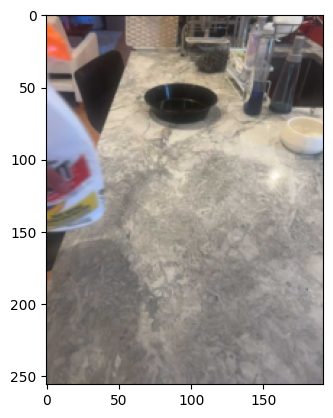

In [13]:
plt.imshow(rgbs_resized[FIRST_SHOUT_T])

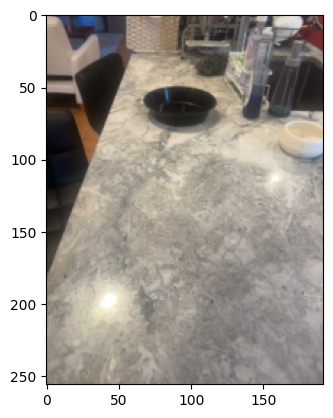

In [14]:
# generate a trace that localizes the background mesh from above
# and sanity-check with the rendering 

num_objs_before_shout = 1  # just the background
color_error, depth_error = (10.0, 0.02)
inlier_score, outlier_prob = (4.0, 0.01)
color_multiplier, depth_multiplier = (1000.0, 1000.0)

bg_arguments = (
        jnp.empty((num_objs_before_shout,)),

        color_error,
        depth_error,

        inlier_score,
        outlier_prob,

        color_multiplier,
        depth_multiplier
    )

bg_trace, _ = model.importance(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        {
            "object_0": 0,  # full background mesh
            "camera_pose": Pose.identity(),
            "object_pose_0": bg_object_pose,
            "observed_rgb": rgbs_resized[TIME_FOR_MESH],
            "observed_depth": xyzs[TIME_FOR_MESH,...,2],
        }
    ),
    bg_arguments
)
bg_obs_rgb, bg_rendered_rgb = bg_trace.get_retval()[0]
plt.imshow(bg_obs_rgb)

In [15]:
######
# Camera pose tracking INCLUDING first shout frame
######
key = jax.random.PRNGKey(0)
chains = []
for T_observed_image in tqdm(range(CAMERATRACK_START_T, CAMERATRACK_END_T, 1)):
    bg_trace = enumerator_observations.update_choices(bg_trace, key,
        rgbs_resized[T_observed_image],
        xyzs[T_observed_image,...,2]
    )
    for _ in range(1):
        bg_trace,key = enumerative_proposal_camera_pose(bg_trace, key)
    chains.append(bg_trace["camera_pose"])

  0%|          | 0/5 [00:00<?, ?it/s]2024-03-31 19:05:02.798398: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %pad.9 = f32[425760,4]{1,0} pad(f32[425760,3]{1,0} %constant.123, f32[] %constant.103), padding=0_0x0_1, metadata={op_name="jit(enumerator)/jit(main)/concatenate[dimension=1]" source_file="<@beartype(genjax._src.core.interpreters.incremental.incremental.wrapped) at 0x7fb3eca953a0>" source_line=67}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-03-31 19:05:04.011823: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.213534416s
Constant fold

(125,)


2024-03-31 19:05:10.739881: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  %pad.27 = f32[425760,4]{1,0} pad(f32[425760,3]{1,0} %constant.16, f32[] %constant.17), padding=0_0x0_1, metadata={op_name="jit(enumerative_proposal_camera_pose)/jit(main)/while/body/jit(enumerator_score)/concatenate[dimension=1]" source_file="<@beartype(genjax._src.core.interpreters.incremental.incremental.wrapped) at 0x7fb3eca953a0>" source_line=67}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-03-31 19:05:10.939357: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.1996057

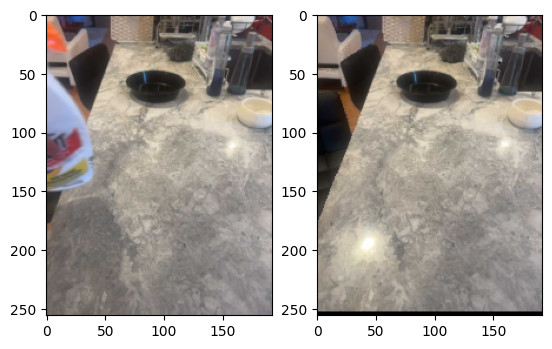

In [16]:
f, axes = plt.subplots(1,2)
axes[0].imshow(bg_trace.get_retval()[0][0])
axes[1].imshow(bg_trace.get_retval()[0][1])

##### Part 2b SHOUT partial mesh acq
Acquire the mesh for SHOUT at the first frame it is shown

In [17]:
# get current inferred latent scene

trace_at_segmentation_time = bg_trace
(observed_rgb_at_seg_t, rendered_rgb_at_seg_t), \
(observed_depth_at_seg_t, rendered_depth_at_seg_t) = trace_at_segmentation_time.get_retval()
cam_pose_at_segmentation_time = bg_trace['camera_pose']

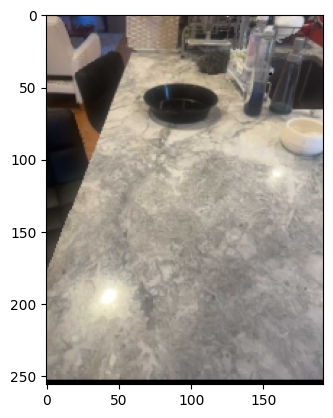

In [18]:
plt.imshow(rendered_rgb_at_seg_t)
# plt.imshow(rendered_rgb_at_seg_t)

In [19]:
### determine a segmentation mask to construct a partial mesh from
from scipy import ndimage

# sobel filter for edges (exclude from "outliers" that go into segmentation)
sx = ndimage.sobel(rendered_depth_at_seg_t, axis=0, mode='constant')
sy = ndimage.sobel(rendered_depth_at_seg_t, axis=1, mode='constant')
sob = np.hypot(sx, sy)
sob *= 255.0 / np.max(sob)

sx1 = ndimage.sobel(xyzs[FIRST_SHOUT_T,...,-1], axis=0, mode='constant')
sy1 = ndimage.sobel(xyzs[FIRST_SHOUT_T,...,-1], axis=1, mode='constant')
sob1 = np.hypot(sx1, sy1)
sob1 *= 255.0 / np.max(sob1)

cie_diff = b3d.colors.ciede2000_err(b3d.colors.rgb_to_lab(rgbs_resized[FIRST_SHOUT_T]), 
                                        b3d.colors.rgb_to_lab(rendered_rgb_at_seg_t))
depth_diff = jnp.abs(rendered_depth_at_seg_t - xyzs[FIRST_SHOUT_T, ..., -1])
pixels_to_cluster = (cie_diff > 10) & (depth_diff > 0.1) & (xyzs[FIRST_SHOUT_T,...,-1] != 0) & (sob < 5) & (sob1 < 5) & (rendered_depth_at_seg_t != 0)

point_cloud_for_obj_mesh = xyzs[FIRST_SHOUT_T][pixels_to_cluster]
colors_for_obj_mesh = rgbs_resized[FIRST_SHOUT_T][pixels_to_cluster]

## TODO add heuristic to clean outliers from pc

_shout_vertices, shout_faces, shout_vertex_colors, shout_face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud_for_obj_mesh, colors_for_obj_mesh, point_cloud_for_obj_mesh[:,2] / fx
)

shout_object_pose = Pose.from_translation(_shout_vertices.mean(0))  # CAMERA frame object pose
shout_vertices = shout_object_pose.inverse().apply(_shout_vertices)  # WORLD frame vertices

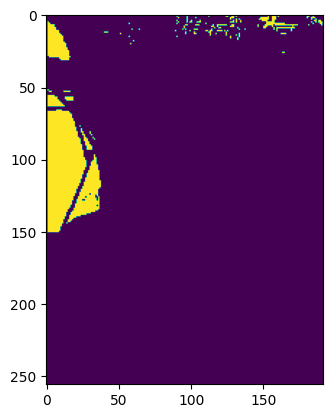

In [20]:
plt.imshow(pixels_to_cluster)

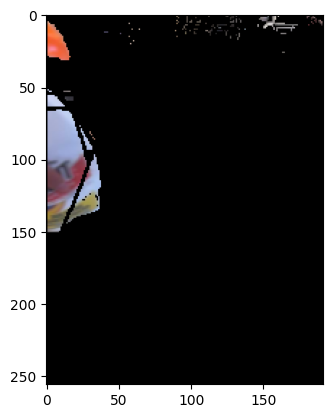

In [21]:
## show masked observation
rgbs_masked_newobj = rgbs_resized[FIRST_SHOUT_T] * pixels_to_cluster[...,None]
xyz_masked_newobj = pixels_to_cluster[...,None] * xyzs[FIRST_SHOUT_T]
plt.imshow(rgbs_masked_newobj)

In [22]:
## Register the partial shout mesh into the library

b3d.LIBRARY = b3d.MeshLibrary()  # reset just in case 

## Register the full background mesh into the library
b3d.LIBRARY.add_object(bg_vertices, bg_faces, bg_vertex_colors, "background")

## Register the partial background mesh into the library
b3d.LIBRARY.add_object(bg_vertices_subset, bg_faces_subset, bg_vertex_colors_subset, "background_partial")

b3d.LIBRARY.add_object(shout_vertices, shout_faces, shout_vertex_colors, "shout_partial")

b3d.LIBRARY.names

['background', 'background_partial', 'shout_partial']

Cam pose + Object pose inference for SHOUT

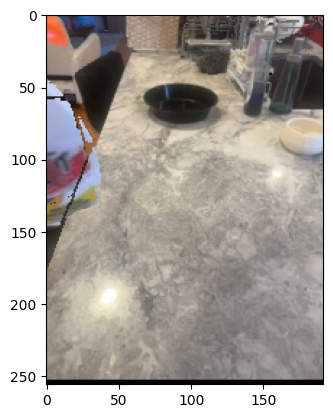

In [23]:
## initialize
# generate a trace that localizes the background mesh from above
# and sanity-check with the rendering 

num_objs_with_shout = 2  # bg + shout
color_error, depth_error = (10.0, 0.02)
inlier_score, outlier_prob = (4.0, 0.01)
color_multiplier, depth_multiplier = (1000.0, 1000.0)

bg_and_shout_arguments = (
        jnp.empty((num_objs_with_shout,)),

        color_error,
        depth_error,

        inlier_score,
        outlier_prob,

        color_multiplier,
        depth_multiplier
    )

bg_and_shout_trace, _ = model.importance(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        {
            "object_0": 0,  # full background mesh
            "object_1": 2,  # partial shout mesh
            "camera_pose": cam_pose_at_segmentation_time,
            "object_pose_0": trace_at_segmentation_time['object_pose_0'],
            "object_pose_1": shout_object_pose,
            "observed_rgb": rgbs_resized[FIRST_SHOUT_T],
            "observed_depth": xyzs[FIRST_SHOUT_T,...,2],
        }
    ),
    bg_and_shout_arguments
)
bg_and_shout_trace_copy = bg_and_shout_trace  # make a copy
(bg_and_shout_obs_rgb, bg_and_shout_rendered_rgb), (bg_and_shout_obs_depth, bg_and_shout_rendered_depth) = bg_and_shout_trace.get_retval()

_viz = b3d.rerun_visualize_trace_t(bg_and_shout_trace, FIRST_SHOUT_T)

plt.imshow(bg_and_shout_rendered_rgb)

In [24]:
key = jax.random.PRNGKey(0)
chains_cam = []
chains_bg = []
chains_obj = []
for T_observed_image in tqdm(range(FIRST_SHOUT_T, VID_END_T, 1)):
    # update obs
    bg_and_shout_trace = enumerator_observations.update_choices(bg_and_shout_trace, key,
        rgbs_resized[T_observed_image],
        xyzs[T_observed_image,...,2]
    )
    
    for _ in range(1):
        # localize camera
        bg_and_shout_trace, key = enumerative_proposal_camera_pose(bg_and_shout_trace, key)

        # localize object
        shout_obj_idx = 1  # idx in the model
        bg_and_shout_trace, key = enumerative_proposal_object_pose(bg_and_shout_trace["camera_pose"], shout_obj_idx, bg_and_shout_trace, key)
    
    chains_cam.append(bg_and_shout_trace["camera_pose"])
    chains_bg.append(bg_and_shout_trace['object_pose_0'])
    chains_obj.append(bg_and_shout_trace["object_pose_1"])


  0%|          | 0/25 [00:00<?, ?it/s]

(125,)


100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


In [25]:
# visualize the mesh 

viz_trace_shout = bg_and_shout_trace

obs_viz = []
rendered_vizs_shout = []
rendered_depth_vizs_shout = []
inlier_vizs_shout = []

for i, T_observed_image in tqdm(enumerate(range(FIRST_SHOUT_T, VID_END_T, 1))):
    viz_trace_shout = enumerator_observations.update_choices(viz_trace_shout, key,
        rgbs_resized[T_observed_image],
        xyzs[T_observed_image,...,2]
    )
    obs_viz.append(rgbs_resized[T_observed_image])
    
    # update cam pose
    cam_pose_viz = chains_cam[i]
    viz_trace_shout = update_jit(jax.random.PRNGKey(0), viz_trace_shout, genjax.choice_map({"camera_pose": cam_pose_viz})) 
    
    # update object pose
    obj_pose_viz = chains_obj[i] 
    
    viz_trace_shout = enumerator_obj_pose.update_choices(viz_trace_shout, key, obj_pose_viz)
    vizs_shout = b3d.rerun_visualize_trace_t(viz_trace_shout, T_observed_image) # (observed_rgb, rendered_rgb, observed_depth, rendered_depth, inlier_match_mask, error)
    rendered_vizs_shout.append(vizs_shout[1])
    rendered_depth_vizs_shout.append(vizs_shout[3])
    inlier_vizs_shout.append(vizs_shout[4])
    
    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = viz_trace_shout.get_retval()
    rr.log("/point_cloud",
        rr.Points3D(
            xyzs[T_observed_image].reshape(-1, 3),
        )
    )
    rr.log("/rendered_point_cloud",
        rr.Points3D(
            b3d.xyz_from_depth(rendered_depth, fx, fy, cx, cy).reshape(-1, 3),
        )
    )

25it [00:12,  1.98it/s]


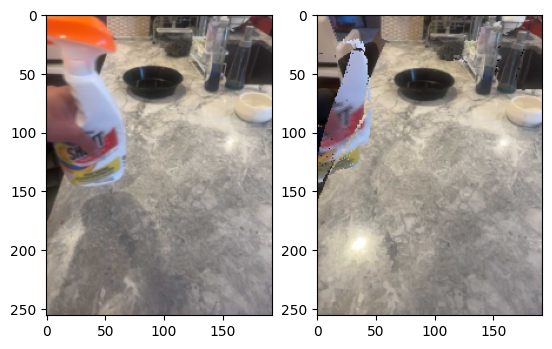

In [32]:
f, axes = plt.subplots(1,2)
i = 2
axes[0].imshow(obs_viz[i])
axes[1].imshow(rendered_vizs_shout[i])

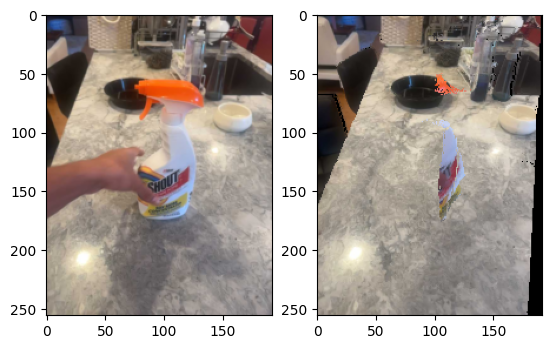

In [35]:
from PIL import Image 

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


fig, axes = plt.subplots(1,3)

images = []
for gt, rend in zip(obs_viz, rendered_vizs_shout):
    axes[0].imshow(gt)
    axes[1].imshow(rend)
    axes[2].imshow(gt+rend)
    images.append(fig2img(fig))
    
images[0].save('partial.gif', save_all=True, append_images=images[1:], loop=0, duration=500)

    

##### full shout mesh

In [27]:
# get current inferred latent scene

trace_at_full_shout_time, _ = model.importance(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        {
            "object_0": 0,  # full background mesh
            "camera_pose": bg_and_shout_trace['camera_pose'],
            "object_pose_0": bg_and_shout_trace['object_pose_0'],
            "observed_rgb": bg_and_shout_trace.get_retval()[0][0],
            "observed_depth": bg_and_shout_trace.get_retval()[1][0],
        }
    ),
    (
        jnp.empty((1,)),

        color_error,
        depth_error,

        inlier_score,
        outlier_prob,

        color_multiplier,
        depth_multiplier
    )
)

(observed_rgb_at_full_shout_t, rendered_rgb_at_full_shout_t), \
(observed_depth_at_full_shout_t, rendered_depth_at_full_shout_t) = trace_at_full_shout_time.get_retval()

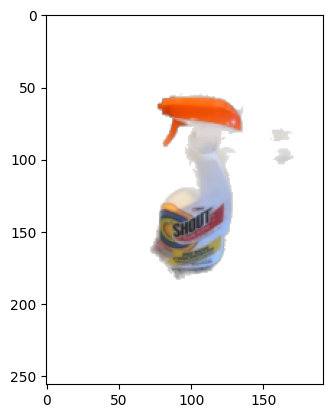

In [28]:
from carvekit.api.high import HiInterface
from PIL import Image

## setup segmentation net
interface = HiInterface(object_type="hairs-like",  # Can be "object" or "hairs-like".
                        batch_size_seg=5,
                        batch_size_matting=1,
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        seg_mask_size=640,  # Use 640 for Tracer B7 and 320 for U2Net
                        matting_mask_size=2048,
                        trimap_prob_threshold=231,
                        trimap_dilation=30,
                        trimap_erosion_iters=5,
                        fp16=False)
output_images = interface([b3d.get_rgb_pil_image(np.asarray(rgbs_resized)[VID_END_T])])
pixels_to_cluster = mask  = jnp.array([jnp.array(output_image)[..., -1] > 0.5 for output_image in output_images])[0]
plt.imshow(output_images[0])